<hr style="height:10px">

<div class='container2'>
    <h1>Compass UOL - Programa de Bolsas Data-Science AWS</h1>
</div>

<hr style="height:5px">

<h2>Projeto da Sprint 8: Risco de inadimplência e crédito em empréstimos</h2>

<h3>Bolsista: Lucas Oliveira</h3>

<hr style="height:2px">


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
from tqdm import tqdm
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
# from sklearn import svm
import math

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler

import pickle
from imblearn.under_sampling import RandomUnderSampler

## Imports

In [344]:
# df = pd.read_csv('conjunto_de_treino.csv')
df = pd.read_csv('conjunto_de_testes.csv')

print('..... Dimensões do DataFrame .....')
print(f'Numero de Linhas: {df.shape[0]}')
print(f'Numero de Colunas: {df.shape[1]}')

..... Dimensões do DataFrame .....
Numero de Linhas: 48744
Numero de Colunas: 141


In [345]:
df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,MONTHS_BALANCE_y,SK_DPD,SK_DPD_DEF,DAYS_DECISION,HOUR_APPR_PROCESS_START_y
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,-1709.0,-1715.0,-57.0,0.0,0.0,-1740.0,13.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,-586.0,-585.0,-20.0,0.0,0.0,-536.0,10.5
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.00,0.00,-1383.0,-1383.0,-21.5,0.0,0.0,-564.5,14.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,6750.0,7311.33,7311.33,-812.0,-812.0,-44.0,0.0,0.0,-998.0,11.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,-622.0,-634.0,-21.0,0.0,0.0,-466.0,5.5


### Funções

- Nesta seção são criadas algumas funções para dinamizar a extração de informações.
    - reduce_mem_usage: Reduz o uso de memória do DataFrame convertendo os tipos de dados para versões mais eficientes.

    - dimensoes: Imprime as dimensões do DataFrame.

    - tipos_dados: Identifica e imprime as variáveis numéricas e categóricas do DataFrame.

    - valores_nulos_por_cols: Retorna um DataFrame com informações sobre valores nulos em cada coluna.

In [346]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def dimensoes(dataframe):
    print('..... Dimensões do DataFrame .....')
    print(f'Numero de Linhas: {dataframe.shape[0]}')
    print(f'Numero de Colunas: {dataframe.shape[1]}')

def tipos_dados(dataframe):
    print('\n..... Tipos de Dados .....')   
    colunas_numericas = dataframe.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
    colunas_categoricas = dataframe.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas (excluindo numéricas)
    # print("\nDivisão do tipo de dados: ")
    print("Variáveis Numéricas")
    print('Quantidade: ',len(colunas_numericas))
    print()
    print(colunas_numericas)

    print("\nVariáveis Categóricas")
    print('Quantidade: ',len(colunas_categoricas))
    return colunas_numericas, colunas_categoricas

# df.isnull().sum().sort_values(ascending=False)
# retorna a quantidade de valores nulos e a porcentagem de valores nulos em cada coluna.
def valores_nulos_por_cols(dataframe):
    df = dataframe
    cont = 0
    nome_col = []
    quantidade_nulos = []
    porcentagem_nulos = []
    for col in df:
        if df[col].isnull().sum() > 0:
            nome_col.append(col)
            quantidade_nulos.append(df[col].isnull().sum())
            porcentagem_nulos.append(round((df[col].isnull().sum() / len(df) * 100), 3))
            cont += 1 
    
    dados = {'nome_col': nome_col, 'quantidade_nulos': quantidade_nulos, 'porcentagem_nulos': porcentagem_nulos}
    
    df_aux = pd.DataFrame(dados)#.head(10).sort_values(by='quantidade_nulos', ascending=False, inplace=True)
    print(f'\nTotal de colunas com valores nulos: {cont}')
    # print(df_aux.head().sort_values(by='quantidade_nulos', ascending=False, inplace=True))
    df_aux.sort_values(by='quantidade_nulos', ascending=False, inplace=True)
    # display(df_aux)
    return  df_aux #dados



In [347]:
# Essa função será apricada apenas para os conjutos de dados derivados do application_train.csv e application_test.csv
def agrupar_categorias(dataframe):
    dataframe['ORGANIZATION_TYPE'] = dataframe['ORGANIZATION_TYPE'].str.replace(r'^Business.*', 'Business',regex=True)
    dataframe['ORGANIZATION_TYPE'] = dataframe['ORGANIZATION_TYPE'].str.replace(r'^Industry.*', 'Industry',regex=True)
    dataframe['ORGANIZATION_TYPE'] = dataframe['ORGANIZATION_TYPE'].str.replace(r'^Trade.*', 'Trade',regex=True)
    dataframe['ORGANIZATION_TYPE'] = dataframe['ORGANIZATION_TYPE'].str.replace(r'^Transport.*', 'Transport',regex=True)
    return dataframe

 Esta função agrupa categorias na coluna ORGANIZATION_TYPE do DataFrame, substituindo valores que começam com "Business", "Industry", "Trade" e "Transport" por "Business", "Industry", "Trade" e "Transport", respectivamente para diminuir a quantidade classes da coluna.

In [348]:
def plot_roc_auc(model, X_test, y_test, model_name):
    # Prever as probabilidades
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular a curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calcular a AUC
    roc_auc = auc(fpr, tpr)
    
    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Reference line (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
def calcular_auc(model, X_teste, y_teste):
    y_probs = model.predict_proba(X_teste)[:, 1]  # Probabilidades da classe positiva
    auc_score = roc_auc_score(y_teste, y_probs)   # Calcula AUC
    return auc_score


def avaliar_modelo(y_esperado, y_predito, nome_modelo):
    # Acurácia
    acc = accuracy_score(y_esperado, y_predito)
    print(f'Acurácia: {acc:.4f}')

    # Relatório de classificação
    print('\nRelatório de Classificação')
    print(classification_report(y_esperado, y_predito))


    # Matriz de confusão
    mtc = confusion_matrix(y_esperado, y_predito)
    plt.figure(figsize=(8, 6))
    sns.heatmap(mtc, annot=True, fmt='d', cmap='magma', cbar=False)
    plt.title(nome_modelo)
    plt.xlabel('Predito')
    plt.ylabel('True labels')
    plt.show()



- plot_roc_auc: Plota a curva ROC e calcula a área sob a curva (AUC) para um modelo.

- avaliar_modelo: Avalia o desempenho de um modelo, imprimindo a acurácia, o relatório de classificação e a matriz de confusão.

## Análise Exploratória de Dados (EDA)

In [349]:
# Aplicando a função para redução de uso de memória
print(df.info())
df = reduce_mem_usage(df)
print('\nApos a transformação de tipos.\n')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 141 entries, SK_ID_CURR to HOUR_APPR_PROCESS_START_y
dtypes: float64(85), int64(40), object(16)
memory usage: 52.4+ MB
None
Memory usage after optimization is: 17.01 MB
Decreased by 67.6%

Apos a transformação de tipos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 141 entries, SK_ID_CURR to HOUR_APPR_PROCESS_START_y
dtypes: float16(75), float32(10), int16(2), int32(2), int8(36), object(16)
memory usage: 17.0+ MB


In [350]:
df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,MONTHS_BALANCE_y,SK_DPD,SK_DPD_DEF,DAYS_DECISION,HOUR_APPR_PROCESS_START_y
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,-1709.0,-1715.0,-57.0,0.0,0.0,-1740.0,13.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,-586.0,-585.0,-20.0,0.0,0.0,-536.0,10.5
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.000000,0.000000,-1383.0,-1383.0,-21.5,0.0,0.0,-564.5,14.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,6750.0,7311.330078,7311.330078,-812.0,-812.0,-44.0,0.0,0.0,-998.0,11.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,-622.0,-634.0,-21.0,0.0,0.0,-466.0,5.5


- A função valores_nulos_por_cols é usada para identificar e contar os valores nulos em cada coluna do DataFrame.

In [351]:
df_aux = valores_nulos_por_cols(df)



Total de colunas com valores nulos: 84


In [352]:
df_aux.tail(40)

,nome_col,quantidade_nulos,porcentagem_nulos
18,LIVINGAREA_AVG,23552,48.318
32,LIVINGAREA_MODE,23552,48.318
28,FLOORSMAX_MODE,23321,47.844
42,FLOORSMAX_MEDI,23321,47.844
14,FLOORSMAX_AVG,23321,47.844
23,YEARS_BEGINEXPLUATATION_MODE,22856,46.890
9,YEARS_BEGINEXPLUATATION_AVG,22856,46.890
37,YEARS_BEGINEXPLUATATION_MEDI,22856,46.890
51,TOTALAREA_MODE,22624,46.414
53,EMERGENCYSTATE_MODE,22209,45.563


In [353]:
lista_drop = df_aux[df_aux['porcentagem_nulos'] > 15]['nome_col'].tolist()
print(len(lista_drop))

57


In [354]:
lista_drop

['COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_AVG',
 'OWN_CAR_AGE',
 'AMT_BALANCE',
 'AMT_DRAWINGS_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'MONTHS_BALANCE_x',
 'AMT_TOTAL_RECEIVABLE',
 'AMT_RECIVABLE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LANDAREA_AVG',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_AVG',
 'ELEVATORS_MODE',
 'ELEVATORS_MEDI',
 'ELEVATORS_AVG',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'HOUSETYPE_MODE',
 'ENTRANCES_MEDI',
 'ENTRANCES_AVG',
 'ENTRANCES_MODE',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMA

Remove as colunas com muitos valores nulos(acima de 15%) e imprime as novas dimensões do DataFrame.

In [355]:
df.drop(columns=lista_drop, inplace=True)
print('..... Dimensões do DataFrame .....')
print(f'Numero de Linhas: {df.shape[0]}')
print(f'Numero de Colunas: {df.shape[1]}')

..... Dimensões do DataFrame .....
Numero de Linhas: 48744
Numero de Colunas: 84


In [356]:
df_aux = valores_nulos_por_cols(df)


Total de colunas com valores nulos: 27


In [357]:
df_aux

,nome_col,quantidade_nulos,porcentagem_nulos
15,DAYS_CREDIT_ENDDATE,6760,13.868
17,AMT_CREDIT_SUM,6425,13.181
14,CREDIT_DAY_OVERDUE,6424,13.179
13,DAYS_CREDIT,6424,13.179
19,DAYS_CREDIT_UPDATE,6424,13.179
18,AMT_CREDIT_SUM_OVERDUE,6424,13.179
16,CNT_CREDIT_PROLONG,6424,13.179
7,AMT_REQ_CREDIT_BUREAU_HOUR,6049,12.410
8,AMT_REQ_CREDIT_BUREAU_DAY,6049,12.410
9,AMT_REQ_CREDIT_BUREAU_WEEK,6049,12.410


- Observando os valores nulos.

In [358]:
# Cria uma lista de colunas que ainda contêm valores nulos e exibe essa lista.
colunas_null = list(df_aux['nome_col'])
print(len(colunas_null))
colunas_null

27


['DAYS_CREDIT_ENDDATE',
 'AMT_CREDIT_SUM',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT',
 'DAYS_CREDIT_UPDATE',
 'AMT_CREDIT_SUM_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'DAYS_DECISION',
 'HOUR_APPR_PROCESS_START_y',
 'SK_DPD_DEF',
 'SK_DPD',
 'MONTHS_BALANCE_y',
 'NAME_TYPE_SUITE',
 'DAYS_ENTRY_PAYMENT',
 'DAYS_INSTALMENT',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'AMT_ANNUITY',
 'EXT_SOURCE_2']

In [359]:
# df.dropna(inplace=True)
# dimensoes(df)

# Os Valores serão preenchidos com a média dos valores da coluna

- Aplica a correlação usando o metodo de pearson para observar uma possivel correlação Linear.

In [360]:
# print('.....MAPAS DE CORRELAÇÃO.....')
correlacoes = df.corr(numeric_only=True,method='pearson')#.drop(columns='FLAG_MOBIL')# ,vmin=-1, vmax=1
# # Ajuste automático do tamanho
# num_cols = correlacoes.shape[1]
# fig_width = num_cols * 1.2  # Ajuste de largura
# fig_height = num_cols * 0.8  # Ajuste de altura

# plt.figure(figsize=(fig_width, fig_height))
# plt.title('Correlação entre as variáveis (metodo de Pearson)')
# sns.heatmap(correlacoes, annot=True, fmt=".2f", vmin=-1, vmax=1);

In [361]:
len(correlacoes)

73

- Ordenação das Correlações com a Variável Alvo

In [362]:
# correlacoes = correlacoes['TARGET'].head(len(correlacoes)).sort_values(ascending=True)

In [363]:
correlacoes

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_CREDIT_SUM,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,MONTHS_BALANCE_y,SK_DPD,SK_DPD_DEF,DAYS_DECISION,HOUR_APPR_PROCESS_START_y
SK_ID_CURR,1.000000,0.000635,0.001278,0.005014,0.007112,0.005097,0.003324,0.002325,-0.000845,0.001036,...,-0.004376,-0.001898,0.001171,-0.000343,-0.000196,-0.000507,0.004539,0.009597,-0.000989,0.009987
CNT_CHILDREN,0.000635,1.000000,0.038962,0.027840,0.056770,0.025507,-0.015222,0.317877,-0.238319,0.175053,...,0.026102,-0.002719,0.024609,-0.009202,-0.009348,-0.010482,-0.000856,0.009200,-0.004811,0.029576
AMT_INCOME_TOTAL,0.001278,0.038962,1.000000,0.396572,0.457833,0.401995,0.199783,0.054400,-0.154619,0.067975,...,0.193832,0.000677,0.049028,-0.006617,-0.006229,-0.004641,-0.000395,-0.002423,-0.004480,0.116992
AMT_CREDIT,0.005014,0.027840,0.396572,1.000000,0.777733,0.988056,0.135699,-0.046169,-0.083483,0.030741,...,0.119837,-0.000573,-0.030642,-0.075517,-0.075781,-0.057718,0.000547,0.003026,-0.082090,0.066500
AMT_ANNUITY,0.007112,0.056770,0.457833,0.777733,1.000000,0.787033,0.150873,0.047859,-0.137772,0.064450,...,0.129077,0.000870,-0.022003,-0.022119,-0.022349,-0.010510,0.001976,0.000662,-0.026763,0.084703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MONTHS_BALANCE_y,-0.000507,-0.010482,-0.004641,-0.057718,-0.010510,-0.059680,-0.033585,0.075098,0.015742,0.054718,...,0.000269,0.001366,0.087040,0.882610,0.882119,1.000000,-0.044279,-0.005487,0.671549,0.012857
SK_DPD,0.004539,-0.000856,-0.000395,0.000547,0.001976,0.000091,0.001188,-0.010068,0.003594,-0.002811,...,0.001403,-0.000633,-0.007132,-0.010108,-0.009073,-0.044279,1.000000,0.301021,-0.001806,0.003146
SK_DPD_DEF,0.009597,0.009200,-0.002423,0.003026,0.000662,0.001531,-0.000897,0.009221,-0.006528,-0.003715,...,0.001706,-0.000152,0.001415,0.007359,0.007646,-0.005487,0.301021,1.000000,0.006612,0.006087
DAYS_DECISION,-0.000989,-0.004811,-0.004480,-0.082090,-0.026763,-0.083157,-0.029488,0.064361,0.016292,0.052675,...,-0.015806,0.002272,0.092451,0.672520,0.672225,0.671549,-0.001806,0.006612,1.000000,-0.016663


 - Cálculo de Correlações Usando o Método de Spearman

In [364]:
correlacoes = df.corr(numeric_only=True,method='spearman') #.drop(columns='FLAG_MOBIL')
# # Ajuste automático do tamanho
# num_cols = correlacoes.shape[1]
# fig_width = num_cols * 1.2  # Ajuste de largura
# fig_height = num_cols * 0.8  # Ajuste de altura

# plt.figure(figsize=(fig_width, fig_height))
# plt.title('Correlação entre as variáveis (metodo de Spearman)')
# sns.heatmap(correlacoes, annot=True, fmt=".2f", vmin=-1, vmax=1);

- Ordena as correlações da variável alvo TARGET em ordem crescente usando o método de Spearman.

In [365]:
# correlacoes['TARGET'].head(len(correlacoes)).sort_values(ascending=True)

Identifica e imprime as variáveis numéricas e categóricas do DataFrame.

In [366]:
colunas_numericas, colunas_categoricas = tipos_dados(df)


..... Tipos de Dados .....
Variáveis Numéricas
Quantidade:  73

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_x',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7'

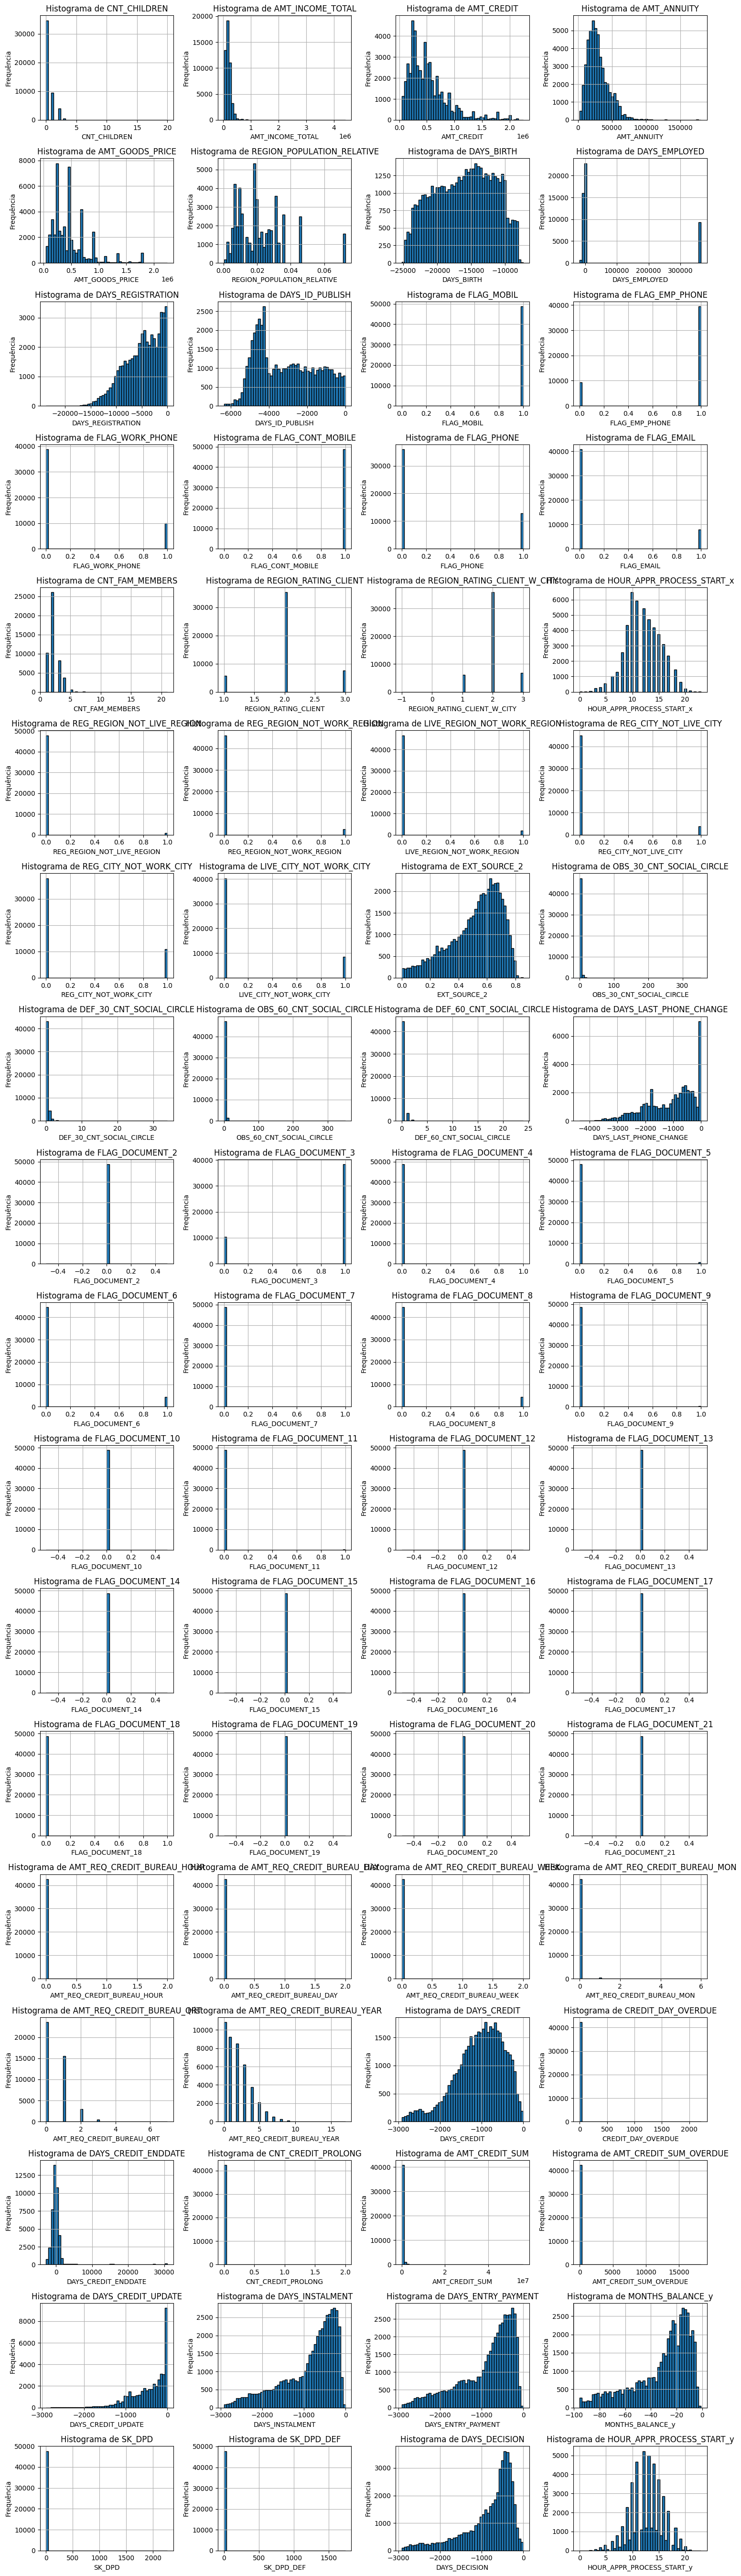

In [367]:
colunas_numericas = colunas_numericas.drop('SK_ID_CURR')
num_cols = len(colunas_numericas)
num_rows = math.ceil(num_cols / 4)  # Ajuste para 4 colunas por linha
plt.figure(figsize=(15, num_rows * 3))

# Criando os histogramas
for i, column in enumerate(colunas_numericas, 1):
    plt.subplot(num_rows, 4, i)
    df[column].hist(bins=50, edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

# histograma das variáveis numéricas sem nenhum tratamento de outliers ou normalização de dados
# df.hist(bins=50, figsize=(8,5)) #['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN']
# plt.show()

### Analise variaveis categoricas

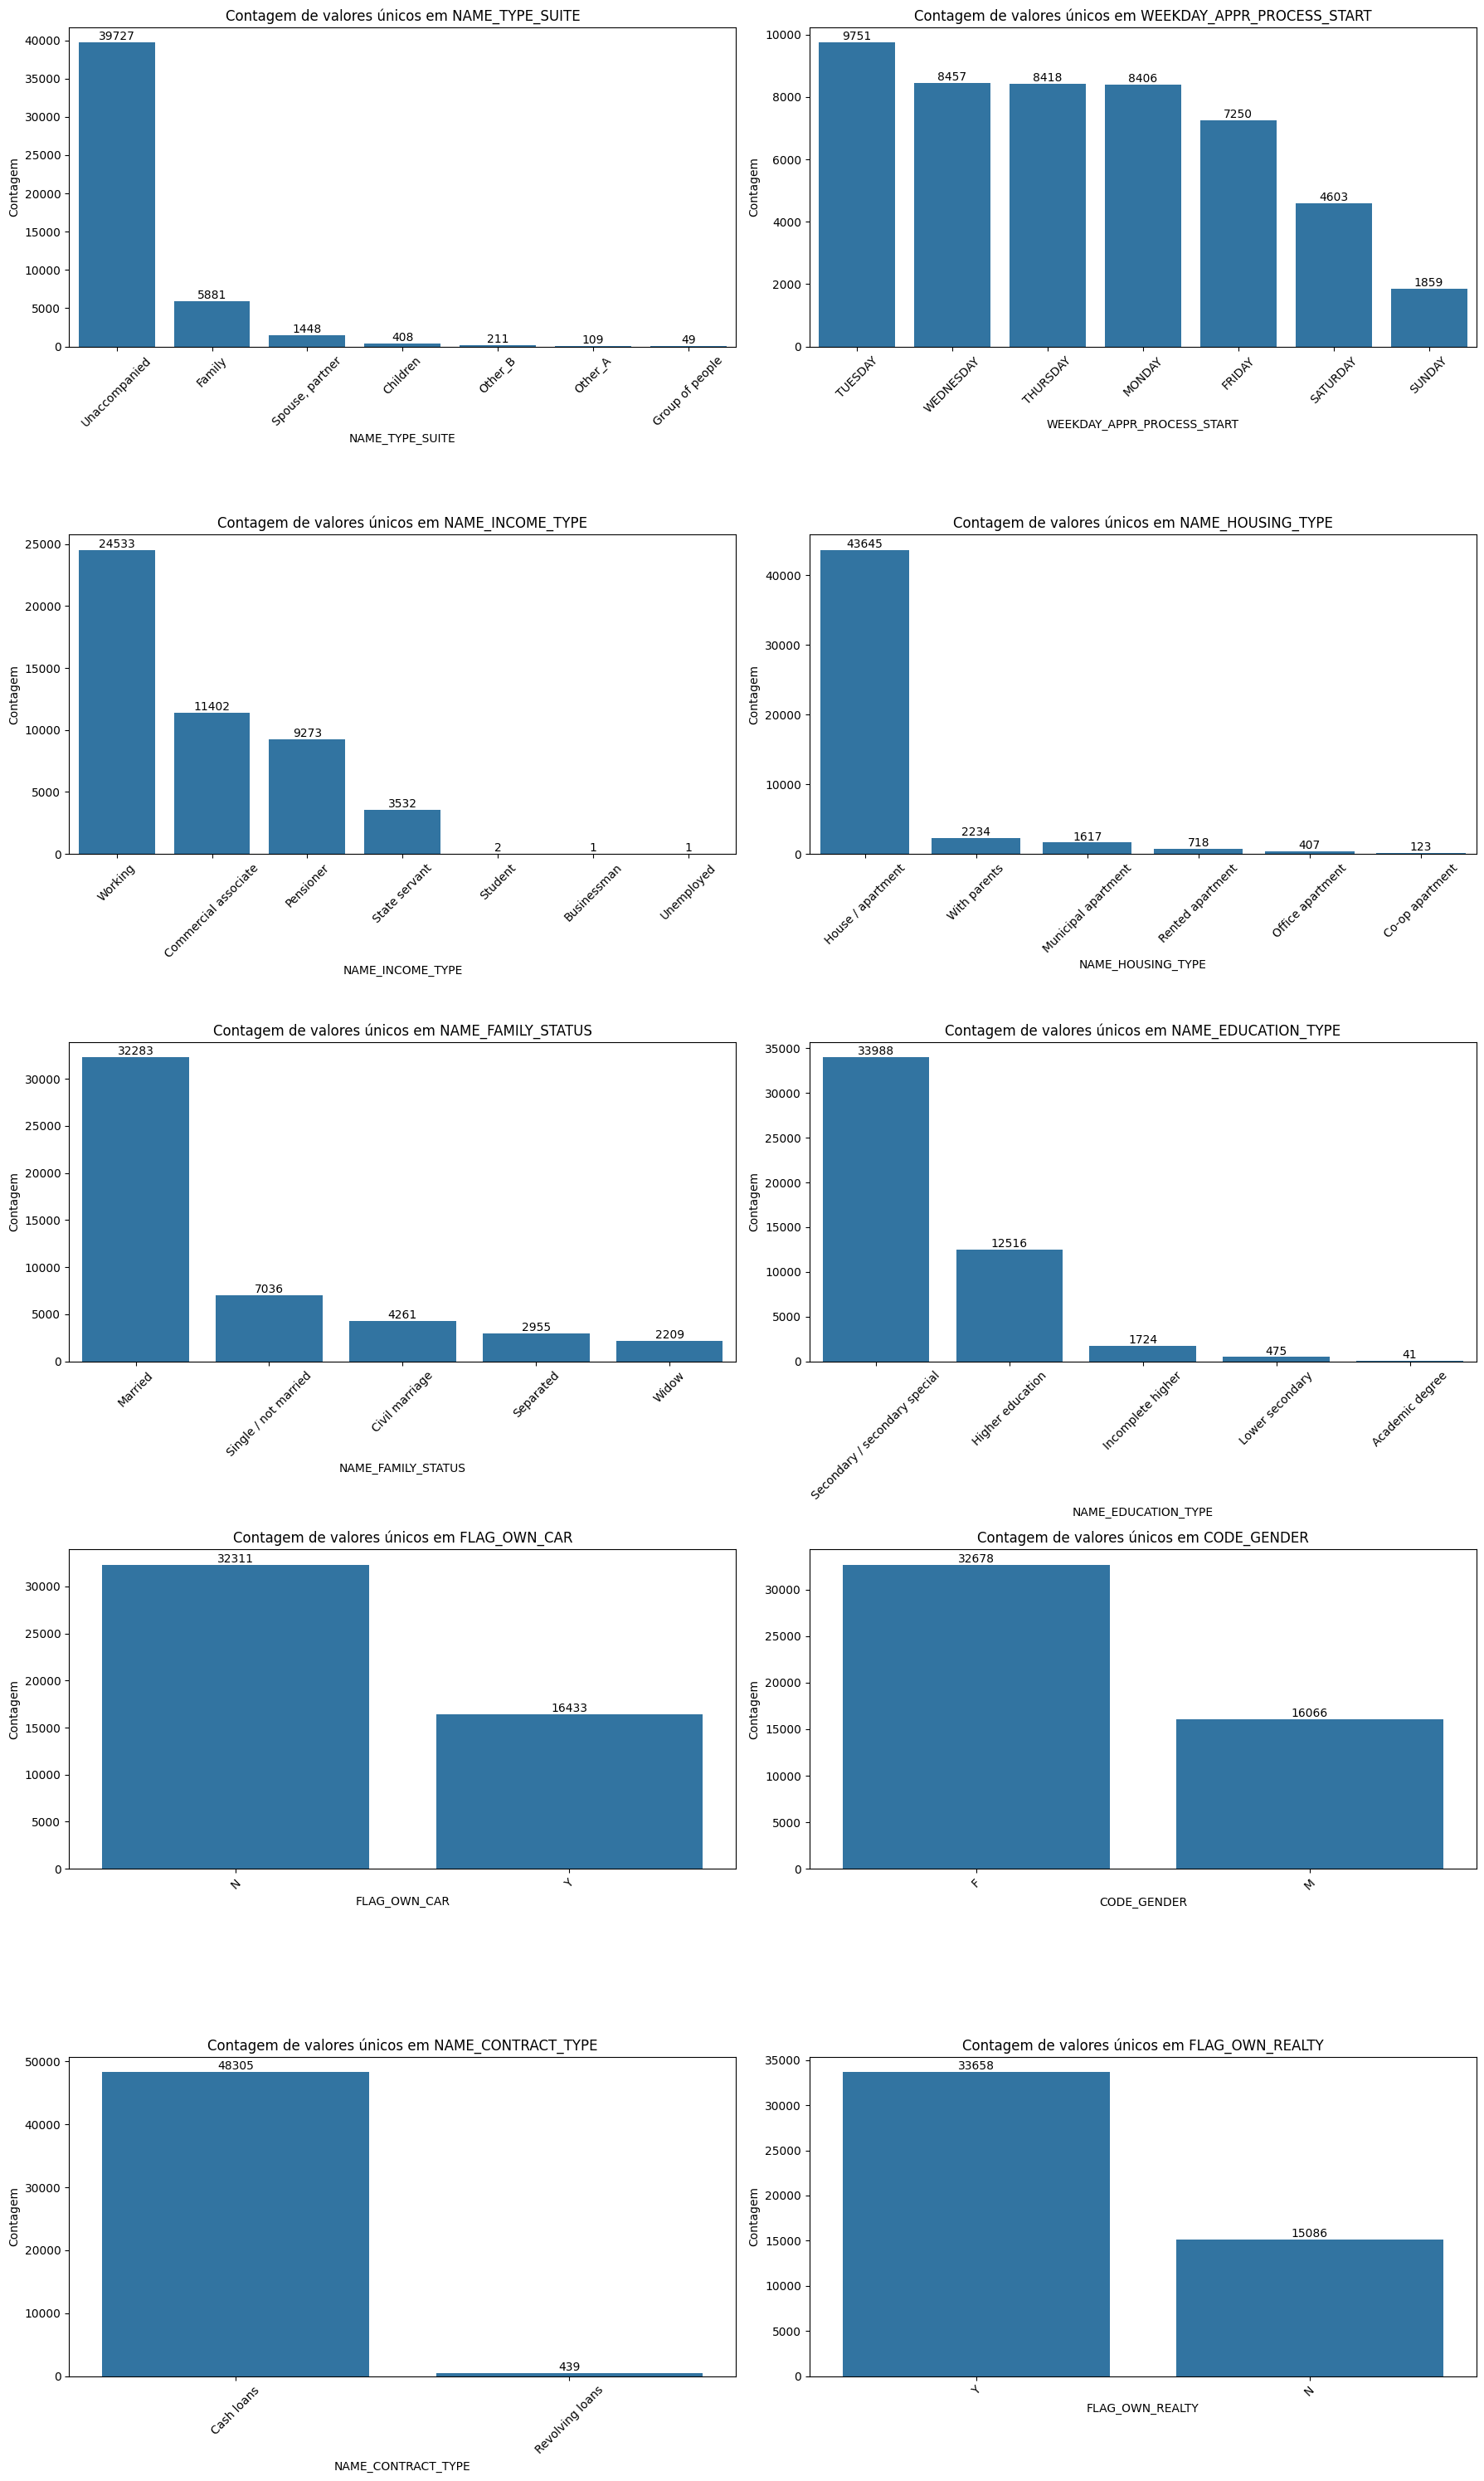

In [368]:
# Contagem de valores diferentes por coluna
contagem = df[colunas_categoricas].nunique().sort_values(ascending=False)

# Remover a coluna 'ORGANIZATION_TYPE'
contagem = contagem.drop('ORGANIZATION_TYPE')
num_cols = len(contagem)
num_rows = math.ceil(num_cols / 2)  # Ajuste para 2 colunas por linha
plt.figure(figsize=(18, num_rows * 6))

# Criando os gráficos
for i, (column, count) in enumerate(contagem.items(), 1):
    plt.subplot(num_rows, 2, i)
    y = df[column].value_counts()
    x = y.index
    ax = sns.barplot(x=x, y=y)
    plt.title(f'Contagem de valores únicos em {column}')
    plt.xlabel(column)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    
    # Adicionando os valores nas barras
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', xy=(p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [369]:
colunas_categoricas

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

como estes registros são pouco significativos em termos de quantidade, eles serão apagados.

In [370]:
df = df[df['NAME_EDUCATION_TYPE'] != 'Academic degree']
df = df[df['CODE_GENDER'] != 'XNA']
df = df[df['NAME_FAMILY_STATUS'] != 'Unknown']

- Tratamento do 'NAME_INCOME_TYPE', serão agrupados em 5 colunas

In [371]:
df['NAME_INCOME_TYPE'].value_counts()* 100 /len(df) 


NAME_INCOME_TYPE
Working                 50.337762
Commercial associate    23.394863
Pensioner               19.021416
State servant            7.237747
Student                  0.004107
Businessman              0.002053
Unemployed               0.002053
Name: count, dtype: float64

In [372]:
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace(['Unemployed', 'Student', 'Businessman', 'Maternity leave'], 'Outros')

In [373]:
df['NAME_INCOME_TYPE'].value_counts()* 100 /len(df) 

NAME_INCOME_TYPE
Working                 50.337762
Commercial associate    23.394863
Pensioner               19.021416
State servant            7.237747
Outros                   0.008213
Name: count, dtype: float64

Como apos a transfomação pode ser comprovado que o atributo outros é pouco significativo, será apagado todos os registro.

In [374]:
df = df[df['NAME_INCOME_TYPE'] != 'Outros']

2. Tratamento da coluna NAME_TYPE_SUITE

In [375]:
df['NAME_TYPE_SUITE'].value_counts()* 100 /len(df) 

NAME_TYPE_SUITE
Unaccompanied      81.496540
Family             12.068010
Spouse, partner     2.971314
Children            0.837800
Other_B             0.433274
Other_A             0.223824
Group of people     0.100618
Name: count, dtype: float64

In [376]:
df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].replace(['Spouse, partner', 'Children', 'Other_B', 'Other_A','Group of people'   ], 'Outros')

In [377]:
df['NAME_TYPE_SUITE'].value_counts()* 100 /len(df) 

NAME_TYPE_SUITE
Unaccompanied    81.496540
Family           12.068010
Outros            4.566829
Name: count, dtype: float64

3. NAME_HOUSING_TYPE

In [378]:
df['NAME_HOUSING_TYPE'].value_counts()* 100 /len(df) 

NAME_HOUSING_TYPE
House / apartment      89.537773
With parents            4.585310
Municipal apartment     3.318343
Rented apartment        1.472309
Office apartment        0.835746
Co-op apartment         0.250518
Name: count, dtype: float64

In [379]:
df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].replace(['With parents', 'Municipal apartment', 'Rented apartment', 'Office apartment','Co-op apartment'   ], 'Outros')

In [380]:
df['NAME_HOUSING_TYPE'].value_counts()* 100 /len(df) 

NAME_HOUSING_TYPE
House / apartment    89.537773
Outros               10.462227
Name: count, dtype: float64

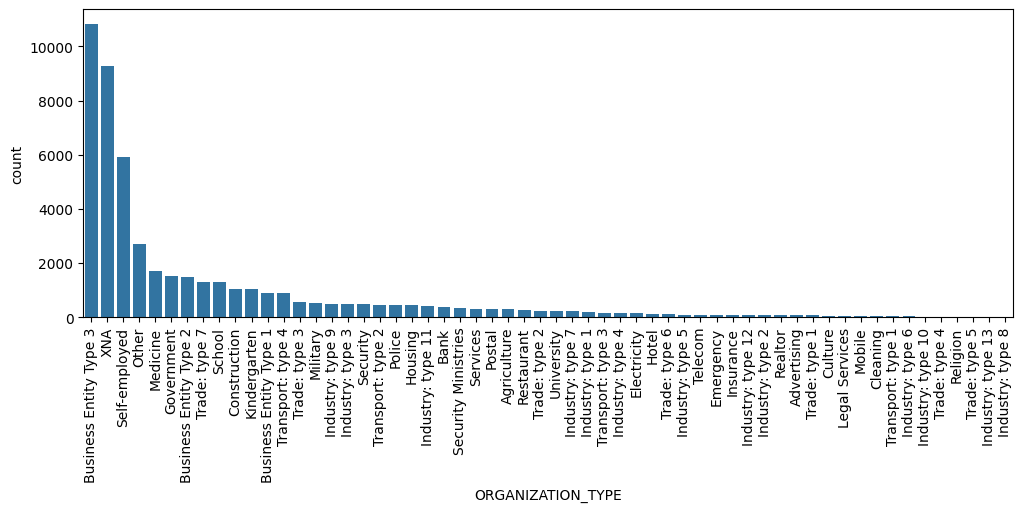

In [381]:
y = df['ORGANIZATION_TYPE'].value_counts()
x = y.index
plt.figure(figsize=(12, 4))
sns.barplot(x=x, y=y)
plt.xticks(rotation=90);

In [382]:
df['ORGANIZATION_TYPE'].value_counts().sort_values(ascending=False) 

ORGANIZATION_TYPE
Business Entity Type 3    10832
XNA                        9264
Self-employed              5916
Other                      2699
Medicine                   1716
Government                 1507
Business Entity Type 2     1476
Trade: type 7              1303
School                     1286
Construction               1038
Kindergarten               1037
Business Entity Type 1      887
Transport: type 4           884
Trade: type 3               577
Military                    530
Industry: type 9            499
Industry: type 3            489
Security                    472
Transport: type 2           448
Police                      441
Housing                     433
Industry: type 11           416
Bank                        374
Security Ministries         340
Services                    302
Postal                      294
Agriculture                 292
Restaurant                  284
Trade: type 2               242
University                  220
Industry: type 7      

- Agrupa as categorias:
    - Business, Industry,Transport, Trade

In [383]:
df = agrupar_categorias(df)

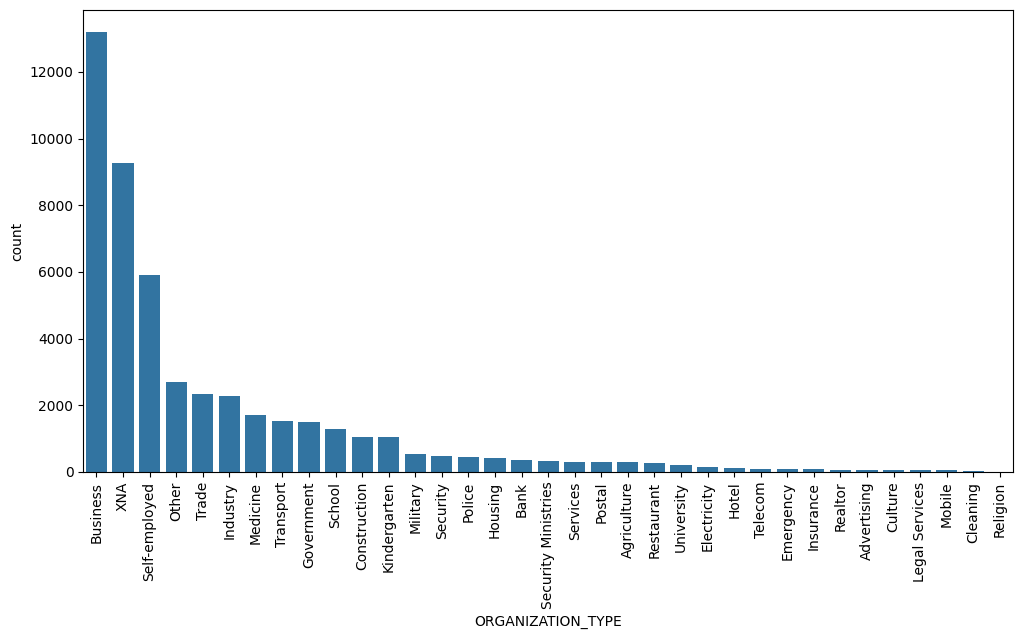

In [384]:
y2 = df['ORGANIZATION_TYPE'].value_counts()
x = y2.index
plt.figure(figsize=(12, 6))
sns.barplot(x=x, y=y2)
plt.xticks(rotation=90);

- Remove os tipos meno significativos, ou seja, abaixo de 1 %.

In [385]:
df.columns
# Calcular a porcentagem de cada valor na coluna 'ORGANIZATION_TYPE'
percentages = df['ORGANIZATION_TYPE'].value_counts() * 100 / len(df)

# Identificar os valores que estão abaixo de 1%
to_remove = percentages[percentages < 1].index

# Remover os registros do DataFrame
df = df[~df['ORGANIZATION_TYPE'].isin(to_remove)]

df['ORGANIZATION_TYPE'].value_counts() * 100 / len(df)

ORGANIZATION_TYPE
Business         29.760696
XNA              20.894512
Self-employed    13.343257
Other             6.087466
Trade             5.257460
Industry          5.135665
Medicine          3.870357
Transport         3.475652
Government        3.398967
School            2.900512
Construction      2.341160
Kindergarten      2.338904
Military          1.195390
Name: count, dtype: float64

In [386]:
# def remove_outliers(df):
#     numeric_cols = df.select_dtypes(include=[np.number]).columns
#     for col in numeric_cols:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         if col in ['SK_ID_CURR', 'TARGET']:
#             continue
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
#     return df

# df2 = remove_outliers(df)
# print(f'Dimensões do DataFrame após remover outliers: {df2.shape}')

# df2['TARGET'].value_counts()

## Transformação dos dados

In [316]:
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']
print(X.shape, y.shape)

# X = df2.drop(columns=['TARGET', 'SK_ID_CURR'])
# y = df2['TARGET']
# print(X.shape, y.shape)

(279773, 82) (279773,)


In [317]:
X.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CN

In [318]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
# Mostrando os conjuntos
print("X_treino:\n", X_treino.shape)
print("\nX_teste:\n", X_teste.shape)
print("\ny_treino:\n", y_treino.shape)
print("\ny_teste:\n", y_teste.shape)

X_treino:
 (195841, 82)

X_teste:
 (83932, 82)

y_treino:
 (195841,)

y_teste:
 (83932,)


In [83]:
# rus = RandomUnderSampler(random_state=42)
# X_treino, y_treino = rus.fit_resample(X_treino, y_treino) #sempre aplicar na base de treino

In [319]:
print("\ny_treino:\n", y_treino.value_counts()* 100 /len(y_treino) )
print("\ny_teste:\n", y_teste.value_counts()* 100 /len(y_teste) )


y_treino:
 TARGET
0    91.831639
1     8.168361
Name: count, dtype: float64

y_teste:
 TARGET
0    91.831483
1     8.168517
Name: count, dtype: float64


In [320]:
# Listar recursos categóricos e numéricos
numeric_features = df.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
numeric_features = numeric_features.drop(['TARGET', 'SK_ID_CURR']) # Removendo a variável alvo 'price'
categorical_features = df.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas (excluindo numéricas)
categorical_features = categorical_features.drop(['ORGANIZATION_TYPE']) # Removendo a variável 'model'

# Etapas de pré-processamento para dados numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',MinMaxScaler() )  #StandardScaler(), MinMaxScaler()
])

# Etapas de pré-processamento para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preenchimento com a moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Codificação One-Hot
])

# Combinar pré-processadores em um transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar o pipeline nos dados de treino
X_treino_transformed = pipeline.fit_transform(X_treino)
X_teste_transformed = pipeline.transform(X_teste)

In [321]:
# Acessar as transformações do Pipeline para cada conjunto de features
preprocessor = pipeline.named_steps['preprocessor']

# 1. Obter os nomes das colunas numéricas (não alteram os nomes)
numeric_transformed_columns = numeric_features

# 2. Obter os nomes das colunas categóricas codificadas
# Acessar o OneHotEncoder dentro do ColumnTransformer
categorical_transformer = preprocessor.named_transformers_['cat']
categorical_transformed_columns = list(
    categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
)

# 3. Combinar todas as colunas
all_transformed_columns = list(numeric_transformed_columns) + categorical_transformed_columns

# Garantir que o X_train_transformed seja convertido para DataFrame
X_train_transformed_dense = X_treino_transformed #.toarray()
X_treino_transformed_df = pd.DataFrame(X_train_transformed_dense, columns=all_transformed_columns)

X_treino_transformed_df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Outros,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0.000000,0.019804,0.159715,0.088686,0.131461,0.636172,0.297576,0.045804,0.797341,0.523413,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.052632,0.007114,0.050562,0.103023,0.050562,0.268540,0.551747,0.045619,0.965832,0.329443,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.014795,0.129531,0.284537,0.122472,0.336784,0.543067,0.034284,0.632296,0.367653,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.009785,0.049438,0.045694,0.049438,0.260511,0.569560,0.046099,0.914073,0.724330,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.010787,0.101124,0.095155,0.101124,0.361504,0.901409,0.045924,0.836900,0.906767,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [391]:
colunas = X_treino_transformed_df.columns

In [323]:
X_treino_transformed_df.shape

(195841, 104)

## Modelos

### Modelo Regressão Logistica

In [324]:
modelo_rl = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')

In [325]:
modelo_rl.fit(X_treino_transformed_df, y_treino)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [326]:
    # Fazer previsões
y_pred = modelo_rl.predict(X_teste_transformed)

Acurácia: 0.6699

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     77076
           1       0.15      0.64      0.24      6856

    accuracy                           0.67     83932
   macro avg       0.55      0.66      0.52     83932
weighted avg       0.89      0.67      0.74     83932



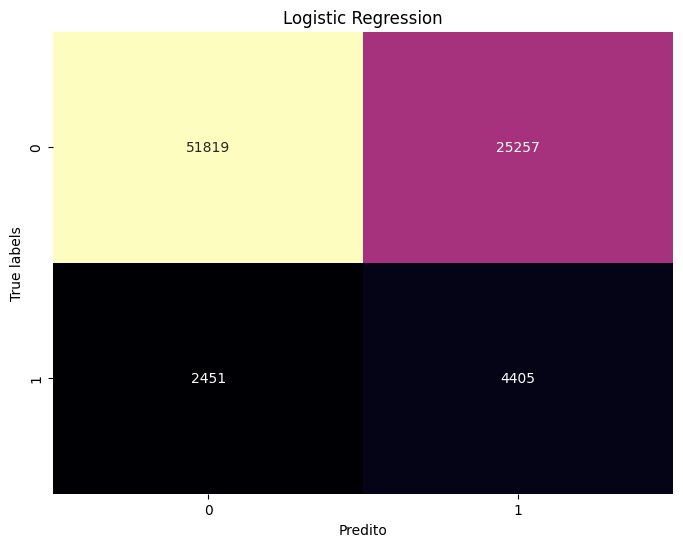

In [328]:
avaliar_modelo(y_teste, y_pred, 'Logistic Regression')

O modelo apresenta uma acurácia de 66,99%, mas a análise das métricas de precisão, recall e F1-score mostra que ele tem desempenho muito diferente entre as classes.

- A classe 0 (negativa) tem alta precisão (0.95), mas um recall baixo (0.67), ou seja, o modelo acerta muitas das previsões de classe 0, mas deixa de identificar um grande número de positivos (falsos negativos).
- A classe 1 (positiva) tem precisão muito baixa (0.15) e um recall alto (0.64). Isso significa que o modelo consegue encontrar boa parte dos casos positivos, mas também classifica muitos negativos incorretamente como positivos (falsos positivos).

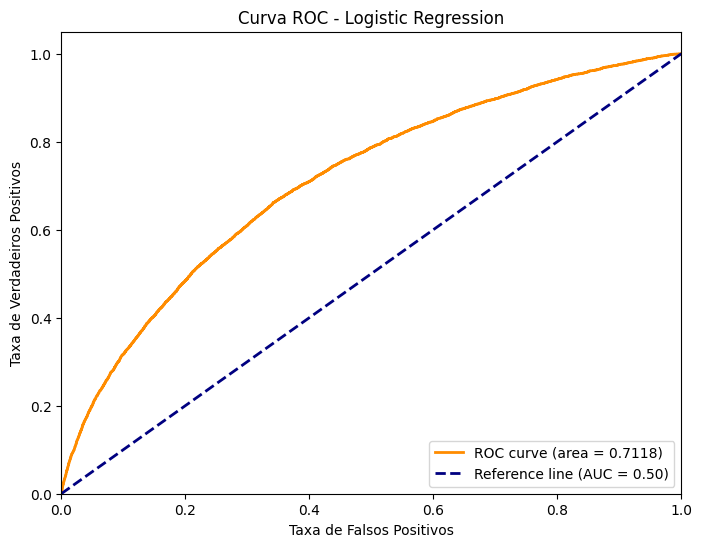

In [329]:
plot_roc_auc(modelo_rl, X_teste_transformed, y_teste, 'Logistic Regression')

In [330]:
auc_valor = calcular_auc(modelo_rl, X_teste_transformed, y_teste)
print(f"AUC: {auc_valor:.2f}")

AUC: 0.71


AUC = 0.7118 indica que, ao escolher aleatoriamente uma amostra positiva e uma negativa, o modelo tem 71,25% de chance de classificar corretamente a positiva como mais provável do que a negativa.

In [ ]:
# y_prob = modelo_rl.predict_proba(X_teste)[:, 1]  # Probabilidades da classe 1
# threshold = 0.4  # Ajuste do limiar
# y_pred = (y_prob >= threshold).astype(int)


### Modelo XGBOOST

In [331]:
# moldelo_xgb = XGBClassifier(n_estimators=78, max_depth=6, learning_rate=0.1, random_state=42, subsample= 0.9, gamma = 0.2)
# moldelo_xgb = XGBClassifier( n_estimators=500, learning_rate=0.05,
#     random_state=42,use_label_encoder=False, eval_metric='auc')

moldelo_xgb = XGBClassifier(n_estimators=180, max_depth=6, learning_rate=0.05, random_state=42, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=10, gamma=0.1)

In [332]:
moldelo_xgb.fit(X_treino_transformed_df, y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [333]:
y_pred =moldelo_xgb.predict(X_teste_transformed)

Acurácia: 0.7407

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     77076
           1       0.17      0.56      0.26      6856

    accuracy                           0.74     83932
   macro avg       0.56      0.66      0.55     83932
weighted avg       0.89      0.74      0.80     83932



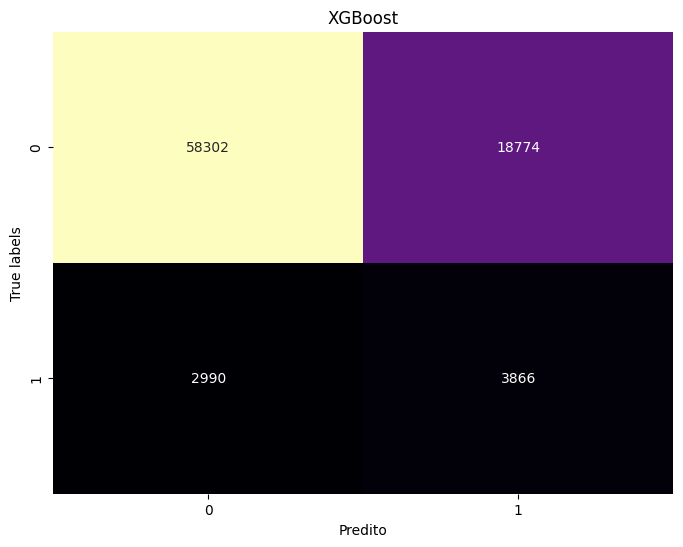

In [334]:
avaliar_modelo(y_teste, y_pred, 'XGBoost')

- Classe 0 
    - O XGBoost teve um recall melhor (0.76 vs 0.67), o que significa que ele identificou mais corretamente os casos da classe 0.
    - No entanto, a precisão da classe 0 caiu um pouco (0.95 vs 0.96), indicando um pequeno aumento nos falsos positivos.
    - F1-Score do XGBoost é maior (0.84 vs 0.79), ou seja, ele tem melhor equilíbrio entre precisão e recall.
Conclusão: O XGBoost melhorou a classificação da classe majoritária, reduzindo falsos negativos.

- Classe 1
    - A precisão da classe 1 subiu de 0.15 para 0.17, o que significa que o XGBoost reduziu um pouco os falsos positivos.
    - O recall da classe 1 caiu (0.64 para 0.56), ou seja, o XGBoost deixou de identificar alguns positivos que a regressão logística conseguia pegar.
    - O F1-score melhorou levemente (0.24 para 0.26), mas ainda está baixo.

Conclusão: O XGBoost piorou um pouco o recall da classe 1, mas equilibrou melhor as previsões, tornando o modelo mais confiável no geral.



<!-- ### Modelo SVM - Kernel polinomial -->

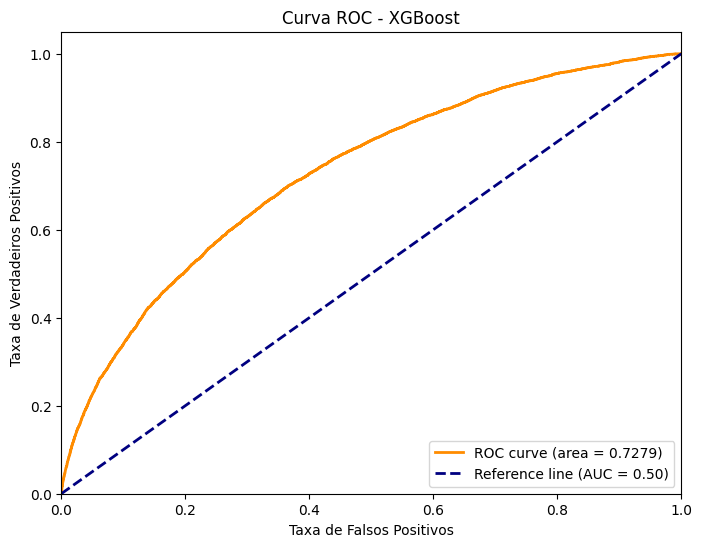

In [335]:
plot_roc_auc(moldelo_xgb, X_teste_transformed, y_teste, 'XGBoost')

AUC = 0.7279 significa que, ao escolher aleatoriamente uma amostra positiva e uma negativa, há 72,79% de chance de o modelo classificar corretamente a amostra positiva com uma probabilidade maior do que a negativa.

### LGBMClassifier


In [336]:
from lightgbm import LGBMClassifier


In [337]:
# moldelo_xgb = XGBClassifier(n_estimators=78, max_depth=6, learning_rate=0.1, random_state=42, subsample= 0.9, gamma = 0.2)

modelo_lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.05, n_estimators=200, subsample_for_bin=200000, objective='binary', class_weight='balanced', min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=0.8, subsample_freq=1, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=0.0, random_state=42, n_jobs=-1)

In [338]:
modelo_lgbm.fit(X_treino_transformed_df, y_treino)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15997, number of negative: 179844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 195841, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_estimators=200, n_jobs=-1,
               objective='binary', random_state=42, subsample=0.8,
               subsample_freq=1)

In [339]:
y_pred =modelo_lgbm.predict(X_teste_transformed)

Acurácia: 0.6956

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     77076
           1       0.16      0.63      0.25      6856

    accuracy                           0.70     83932
   macro avg       0.56      0.67      0.53     83932
weighted avg       0.89      0.70      0.76     83932



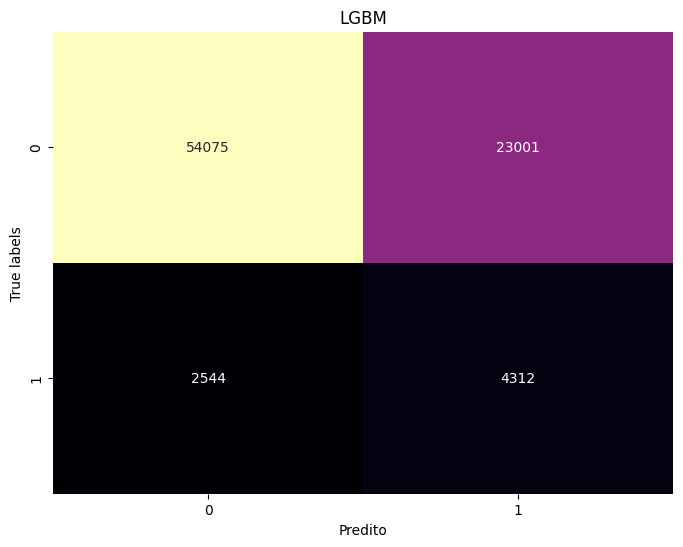

In [340]:
avaliar_modelo(y_teste, y_pred, 'LGBM')

- Classe 0 
    - A precisão do LGBM foi a melhor (0.96), ou seja, quando prevê 0, ele quase sempre acerta.
    - O recall foi intermediário (0.70), melhor que a Regressão Logística (0.67), mas pior que o XGBoost (0.76).
    - F1-Score de 0.81, mostrando que o modelo tem um bom equilíbrio para a classe negativa.
Conclusão: O LGBM consegue prever a classe negativa de forma confiável, mas ainda perde um pouco de recall em relação ao XGBoost.

- Classe 1
    - A precisão do LGBM (0.16) foi ligeiramente melhor que a da Regressão Logística (0.15), mas menor que a do XGBoost (0.17).
    - O recall da classe 1 foi de 0.63, próximo ao da Regressão Logística (0.64) e maior que o do XGBoost (0.56).
    - F1-Score foi de 0.25, um equilíbrio melhor do que a Regressão Logística e quase igual ao XGBoost.
Conclusão: O LGBM tem um recall alto para a classe 1, indicando que ele consegue encontrar mais positivos do que o XGBoost, mas sua precisão ainda é baixa.



<!-- ### Modelo SVM - Kernel polinomial -->

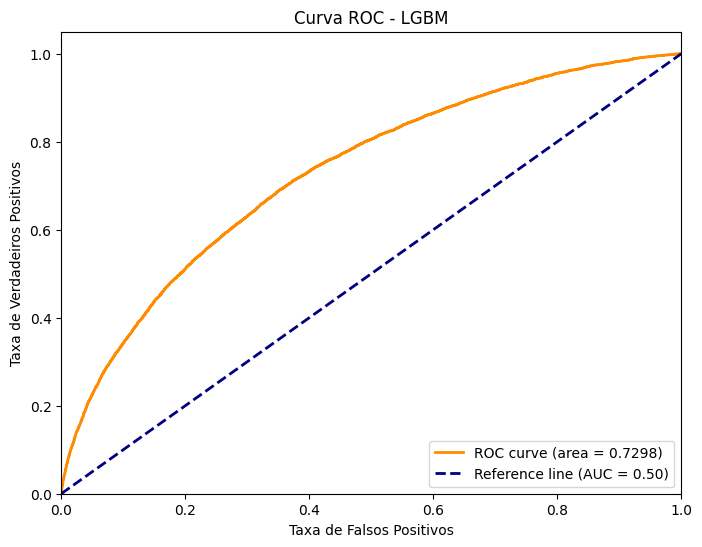

In [341]:
plot_roc_auc(modelo_lgbm, X_teste_transformed, y_teste, 'LGBM')

In [74]:
auc_valor = calcular_auc(modelo_lgbm, X_teste_transformed, y_teste)
print(f"AUC: {auc_valor:.2f}")

AUC: 0.73


AUC = 0.7298 significa que, ao escolher aleatoriamente uma amostra positiva e uma negativa, há 72,98% de chance de o modelo classificar corretamente a amostra positiva com uma probabilidade maior do que a negativa.

Isso indica um desempenho moderado a bom do modelo, melhor do que um classificador aleatório (AUC = 0.5), mas ainda longe de um modelo ideal (AUC = 1.0).

## Conclusão

1. Escolhendo o Melhor Modelo para Risco de Crédito


No contexto de risco de crédito, o objetivo principal é prever se um cliente pode ou não dar um calote (default). Normalmente, a classe de inadimplentes (1) é minoritária, tornando esse um problema de classificação desbalanceada. Assim, métricas como ***recall da classe 1***, F1-score e AUC-ROC são fundamentais para a escolha do melhor modelo.

#### Escolha foi pelo modelo LGBM

Por ter o melhor AUC-ROC e recall competitivo, ele parece ser o mais adequado para risco de crédito.

## Exportando mododelo

In [342]:
with open('modelo_lgbm.pkl', 'wb') as file:
    pickle.dump(modelo_lgbm, file)


# Conjunto Testes (application_test.csv)

In [395]:
with open('modelo_lgbm.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
X_teste = df.drop(columns=['SK_ID_CURR'])
print(X_teste.shape)


(44337, 83)


In [401]:
SK_ID_CURR = df['SK_ID_CURR']

In [388]:
# Listar recursos categóricos e numéricos
numeric_features = df.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
numeric_features = numeric_features.drop(['SK_ID_CURR']) #'TARGET',  Removendo a variável alvo 'price'
categorical_features = df.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas (excluindo numéricas)
categorical_features = categorical_features.drop(['ORGANIZATION_TYPE']) # Removendo a variável 'model'

# Etapas de pré-processamento para dados numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',MinMaxScaler() )  #StandardScaler(), MinMaxScaler()
])

# Etapas de pré-processamento para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preenchimento com a moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Codificação One-Hot
])

# Combinar pré-processadores em um transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar o pipeline nos dados de treino
X_treino_transformed = pipeline.fit_transform(X_teste)
X_teste_transformed = pipeline.transform(X_teste)

In [389]:
# Acessar as transformações do Pipeline para cada conjunto de features
preprocessor = pipeline.named_steps['preprocessor']

# 1. Obter os nomes das colunas numéricas (não alteram os nomes)
numeric_transformed_columns = numeric_features

# 2. Obter os nomes das colunas categóricas codificadas
# Acessar o OneHotEncoder dentro do ColumnTransformer
categorical_transformer = preprocessor.named_transformers_['cat']
categorical_transformed_columns = list(
    categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
)

# 3. Combinar todas as colunas
all_transformed_columns = list(numeric_transformed_columns) + categorical_transformed_columns

# Garantir que o X_teste_transformed seja convertido para DataFrame
X_teste_transformed_dense = X_teste_transformed #.toarray()
X_teste_transformed_df = pd.DataFrame(X_teste_transformed_dense, columns=all_transformed_columns)

X_teste_transformed_df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Outros,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0.00,0.034600,0.238037,0.102453,0.184049,0.257300,0.334063,0.039545,0.782198,0.872086,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.00,0.023073,0.080785,0.084558,0.061350,0.491914,0.400101,0.033953,0.615644,0.744329,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.056214,0.280965,0.378515,0.265849,0.260890,0.289345,0.033982,0.908294,0.448173,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.10,0.092236,0.695297,0.262078,0.695297,0.361831,0.629468,0.040755,0.915711,0.337114,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.05,0.049009,0.263804,0.166995,0.263804,0.135346,0.681984,0.039905,0.831423,0.328607,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Garante que são as mesmas colunas do conjunto de treino
X_teste_transformed_df= X_teste_transformed_df[colunas]

In [398]:
X_teste_transformed_df.shape

(44337, 104)

#### Predição e criação do df resultado

In [399]:
y_pred = loaded_model.predict(X_teste_transformed_df)
print(y_pred)

[0 1 0 ... 0 0 1]


In [403]:
df_result = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'PREDICTION': y_pred})
df_result.head()

,SK_ID_CURR,PREDICTION
0,100001,0
1,100005,1
2,100013,0
3,100028,1
4,100038,0


In [405]:
df_result.to_csv('resultado.csv', index=False)